Calculation of Unmixing Coefficients and G Parameter
====================================================
---
_Borys Olifirov, 07.2023_

## Theoretical intro

Based on _Zal and Gascoigne, 2004, doi: 10.1529/biophysj.103.022087_

__Intensity notation__

$$I_{XM(T)}$$

- X - excitation type
- M - emission type
- T - transfection type (A if acceptor only cells), does not present for co-transfected cells


### Sensitized-emission

$$F_c = I_{DA} - a (I_{AA} - c I_{DD}) - d (I_{DD} - b I_{AA})$$

$$F_c = I_{DA} - a I_{AA} - d I_{DD}$$
$$if$$
$$b \approx c \approx 0$$


### Crosstalc caliration

$$a = \frac{I_{DA(A)}}{I_{AA(A)}}$$
$$b = \frac{I_{DD(A)}}{I_{AA(A)}}$$
$$c = \frac{I_{AA(D)}} {I_{DD(D)}}$$
$$d = \frac{I_{DA(D)}} {I_{DD(D)}}$$

$$b \approx c \approx 0$$


### Determination of the G parameter

$$G = \frac{F_c}{I_{DD}^{post} - I_{DD}} = \frac{(I_{DA} - a I_{AA} - d I_{DD}) - (I_{DA}^{post} - a I_{AA}^{post} - d I_{DD}^{post})}{I_{DD}^{post} - I_{DD}}$$

$$\Delta I_{DD} = G \cdot \Delta F_c$$


### E-FRET

$$E_{app} = \frac{R}{R+G}, R = \frac{F_c}{I_{DD}}$$

$$E_{corr} = E_{app}(t) \frac{[A^0]_{tot}}{[A^t]_{tot}} = E_{app}(t) \times \frac{\overline{I_{AA}^0 - c I_{DD}^0}}{\overline{I_{AA}(t) - c I_{DD}(t)}}$$

## Script

In [1]:
import numpy as np
from numpy import ma
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as anm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap

import plotly.express as px

from skimage.util import montage
from skimage.filters import rank
from skimage import morphology
from skimage import exposure
from skimage import measure
from skimage import filters
from skimage import io
from skimage import transform
from skimage import registration

from scipy import ndimage
from scipy import signal
from scipy import stats
from scipy import ndimage as ndi

from domb.fret.e_fret import coef_calc
from domb.utils import masking

### Crosstalk (8.06.2023)

#### NEW px-wise

donor_reg = {'01':[400, 200],  # [exp 435 ms, exp 505 ms]
             '02':[700, 300],
             '03':[500, 400]}
acceptor_reg = {'04':[500, 100],  # '05':[700, 200],
                '06':[500, 300]}

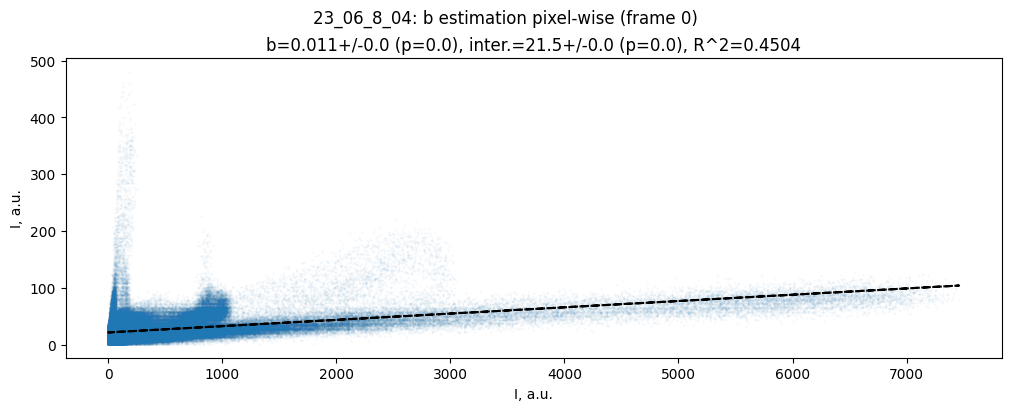

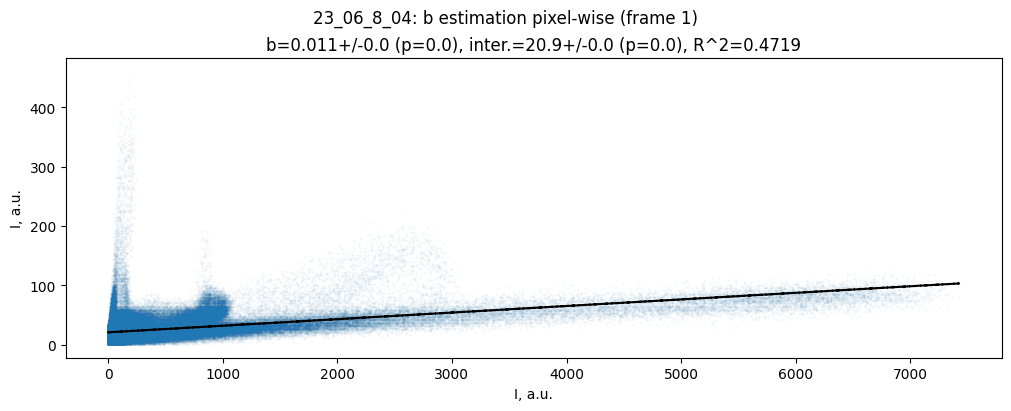

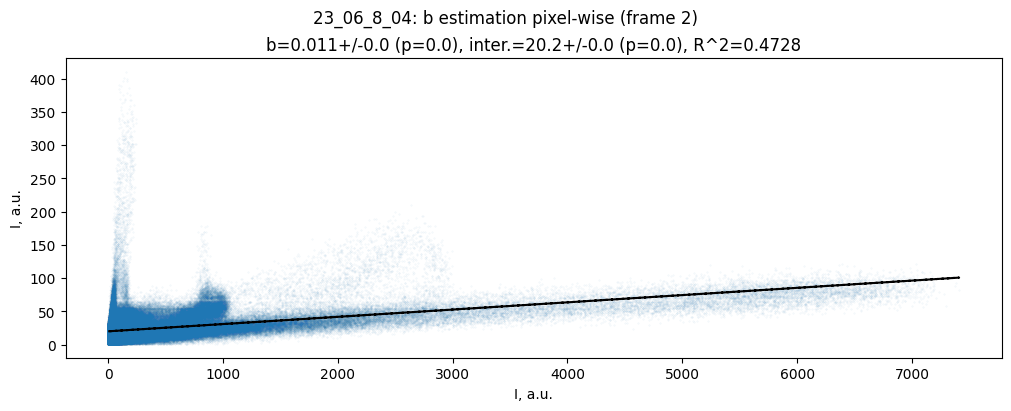

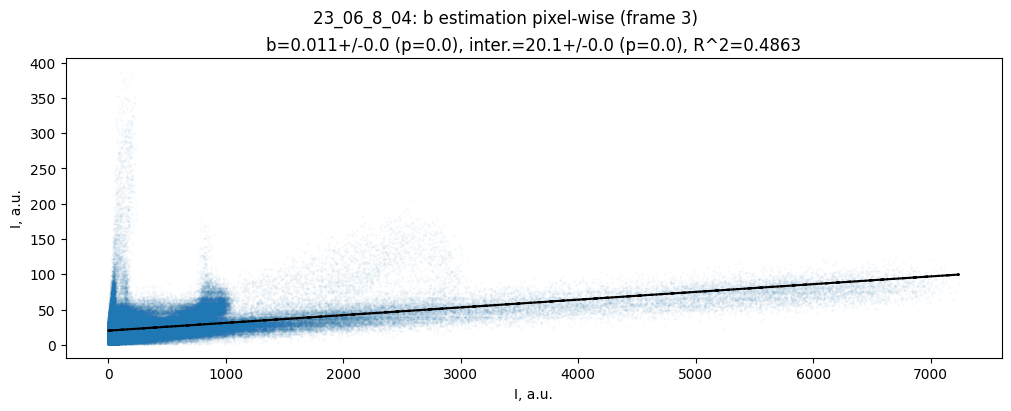

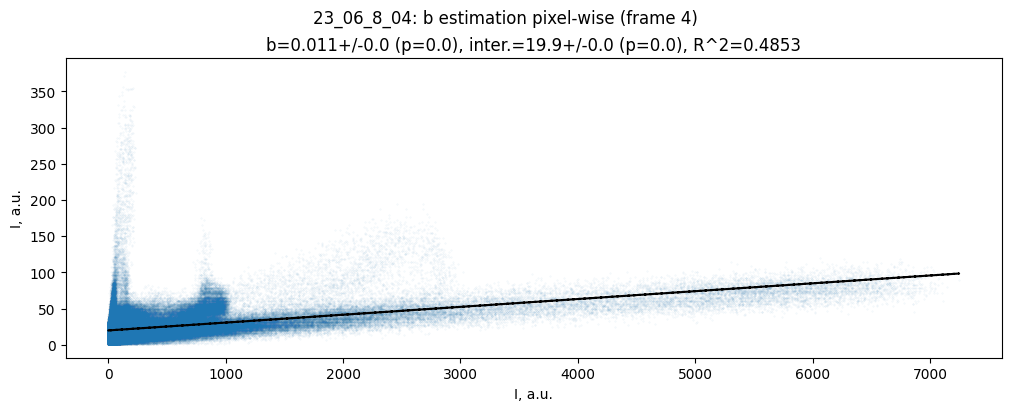

In [32]:
cross_img = io.imread('/home/wisstock/bio_data/chemLTD/fret_calibration/crosstalk/04.tif')[:5]

cross_img = coef_calc.CrossReg(img=cross_img, img_name='23_06_8_04', img_type='A', exp_list=[500,100])

for i in range(5):
    cross_img.cross_fit_px(frame_num=i, mode='b')

#### OLD with frames

In [ ]:
img_path = '/home/wisstock/bio_data/chemLTD/fret_calibration/crosstalk/'

donor_reg = {'01':[400, 200],  # [exp 435 ms, exp 505 ms]
             '02':[700, 300],
             '03':[500, 400]}
acceptor_reg = {'04':[500, 100],  # '05':[700, 200],
                '06':[500, 300]}

calib_reg = coef_calc.CrossRegSet(data_path=img_path,
                             donor_reg_dict = donor_reg,
                             acceptor_reg_dict=acceptor_reg)

In [ ]:
abcd_df = calib_reg.get_abcd()
abcd_df

In [ ]:
calib_reg.cross_raw_df

In [ ]:
a_mean = np.mean(abcd_df['val'][(abcd_df['coef'] == 'a') & (abcd_df['ID'] != '05')])
a_sd = np.std(abcd_df['val'][(abcd_df['coef'] == 'a') & (abcd_df['ID'] != '05')])
print(f'a={round(a_mean, 4)}+/-{round(a_sd, 4)}')

b_mean = np.mean(abcd_df['val'][(abcd_df['coef'] == 'b') & (abcd_df['ID'] != '05')])
b_sd = np.std(abcd_df['val'][(abcd_df['coef'] == 'b') & (abcd_df['ID'] != '05')])
print(f'b={round(b_mean, 4)}+/-{round(b_sd, 4)}')

c_mean = np.mean(abcd_df['val'][(abcd_df['coef'] == 'c') & (abcd_df['ID'] != '03')])
c_sd = np.std(abcd_df['val'][(abcd_df['coef'] == 'c') & (abcd_df['ID'] != '03')])
print(f'c={round(c_mean, 4)}+/-{round(c_sd, 4)}')

d_mean = np.mean(abcd_df['val'][abcd_df['coef'] == 'd'])
d_sd = np.std(abcd_df['val'][abcd_df['coef'] == 'd'])
print(f'd={round(d_mean, 4)}+/-{round(d_sd, 4)}')


fig = px.box(calib_reg.cross_raw_df, x='coef', y='val', color='ID', points='all')
fig.show()

Concatenation of all coeficients data frames

__a__=0.144+/-0.0318

__b__=0.1292+/-0.0027

__c__=0.2458+/-0.0298

__d__=0.8506+/-0.0138


Vis.

### G parameter

In [26]:
# tandem_path = '/home/wisstock/bio_data/chemLTD/fret_calibration/tandem/'
tandem_path = '/home/wisstock/bio_data/chemLTD/24_03_8/drift/'

# raw_pre = io.imread(tandem_path + '03.tif')[10:]
# raw_post = io.imread(tandem_path + '04.tif')[10:]

raw_pre = io.imread(tandem_path + '24_03_8_tandem_04.tif')[:20]
raw_post = io.imread(tandem_path + '24_03_8_tandem_06.tif')[:20]

beads_img = io.imread('/home/wisstock/bio_data/chemLTD/24_03_8/drift/beads_01.tif')[0]

print(raw_pre.shape)
print(beads_img.shape)

(20, 1040, 696, 4)
(2, 1040, 696)


#### Registration

In [28]:
def restore_cfp_yfp_g(offset_series_pre, offset_series_post, master_img,
                   input_crop:int=15, output_crop:int=10, show_pic:bool=False):
    from dipy.align.transforms import AffineTransform2D
    from dipy.align.imaffine import AffineRegistration

    if (offset_series_pre.ndim == 4) and (offset_series_post.ndim == 4):
        if input_crop != 0:
            y, x = offset_series_pre.shape[1:3]
            offset_series_pre = offset_series_pre[:,input_crop:y-input_crop,input_crop:x-input_crop,:]
            offset_series_post = offset_series_post[:,input_crop:y-input_crop,input_crop:x-input_crop,:]
            master_img = master_img[:,input_crop:y-input_crop,input_crop:x-input_crop]

        master_img_ref, master_img_offset = master_img[1], master_img[0]
        affreg = AffineRegistration()
        transform = AffineTransform2D()
        affine = affreg.optimize(master_img_ref, master_img_offset,
                                 transform, params0=None)
        master_img_xform = affine.transform(master_img_offset)

        masking.misalign_estimate(master_img_ref, master_img_offset,
                                  title='Master Raw', show_img=show_pic)
        masking.misalign_estimate(master_img_ref, master_img_xform,
                                  title='Master Xform', show_img=show_pic)

        def series_reg(img_series):
            # print(img_series.shape, np.mean(img_series, axis=(0,1,2)))
            ch0_xform = np.asarray([affine.transform(frame) for frame in img_series[:,:,:,0]])
            ch2_xform = np.asarray([affine.transform(frame) for frame in img_series[:,:,:,2]])

            xform_series = np.stack((ch0_xform, img_series[:,:,:,1], ch2_xform, img_series[:,:,:,3]),
                                    axis=-1)
            # print(xform_series.shape, np.mean(xform_series, axis=(0,1,2)))

            if output_crop != 0:
                yo, xo = xform_series.shape[1:3]
                xform_series = xform_series[:,output_crop:yo-output_crop,output_crop:xo-output_crop,:]
                # print(xform_series.shape)

            masking.misalign_estimate(np.mean(img_series[:,:,:,0], axis=0), np.mean(img_series[:,:,:,-1], axis=0),
                                      title='Raw', show_img=show_pic)
            masking.misalign_estimate(np.mean(xform_series[:,:,:,0], axis=0), np.mean(xform_series[:,:,:,-1], axis=0),
                                      title='Xform', show_img=show_pic)
            return xform_series

        xform_series_pre = series_reg(offset_series_pre)
        xform_series_post = series_reg(offset_series_post)

        return xform_series_pre, xform_series_post

    elif (offset_series_pre.ndim != 4) or (offset_series_post.ndim != 4):
        raise ValueError('Incorrect image shape!')
    

pre, post = restore_cfp_yfp_g(offset_series_pre=raw_pre, offset_series_post=raw_post, master_img=beads_img,
                              input_crop=25, output_crop=10, show_pic=False)

Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]
Master Raw shift [-3. -2.], phase difference 1.05E-08
Master Xform shift [0. 1.], phase difference 2.91E-11
Raw shift [0. 0.], phase difference 8.25E-18
Xform shift [0. 0.], phase difference 8.84E-18
Raw shift [0. 0.], phase difference 4.49E-18
Xform shift [0. 0.], phase difference 2.71E-17


#### Parameters

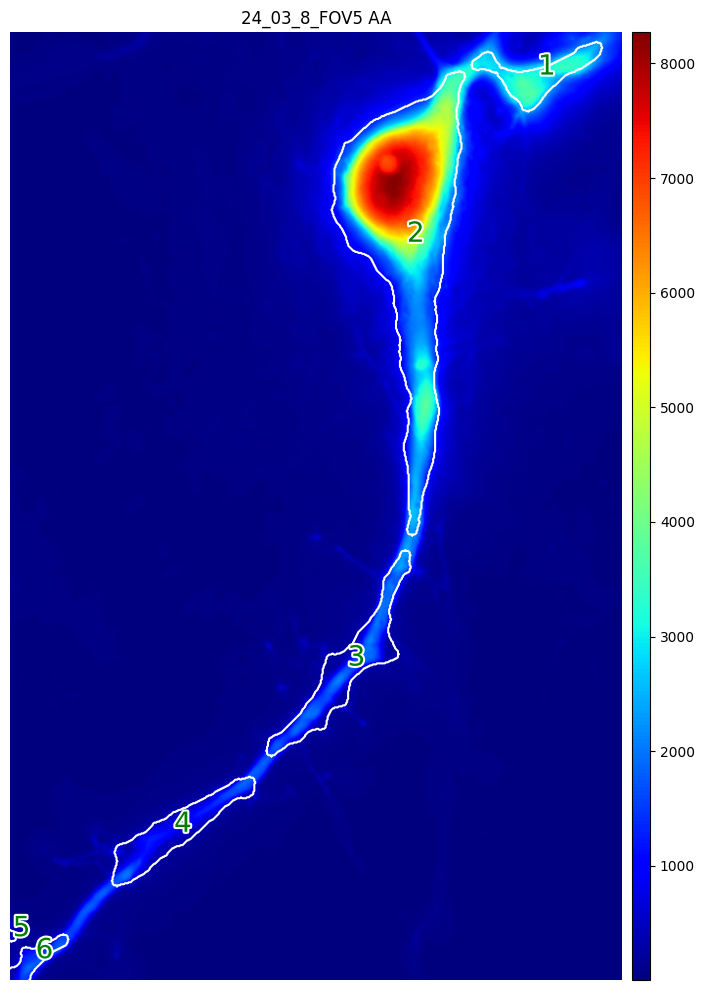

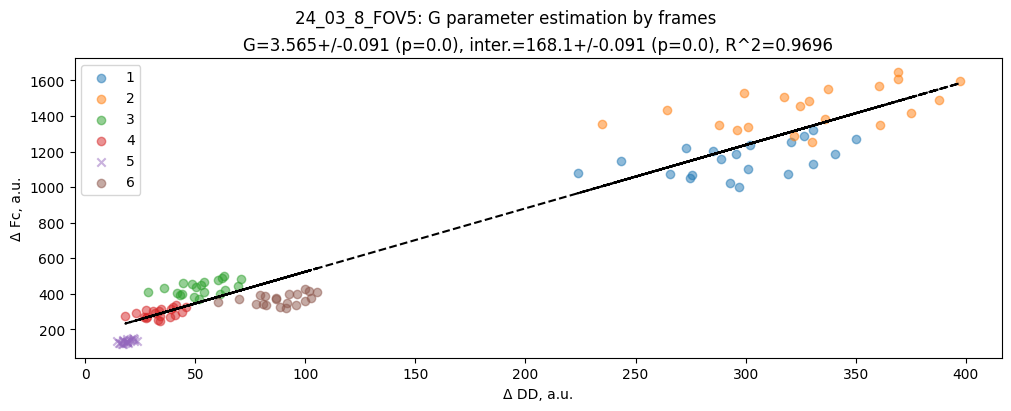

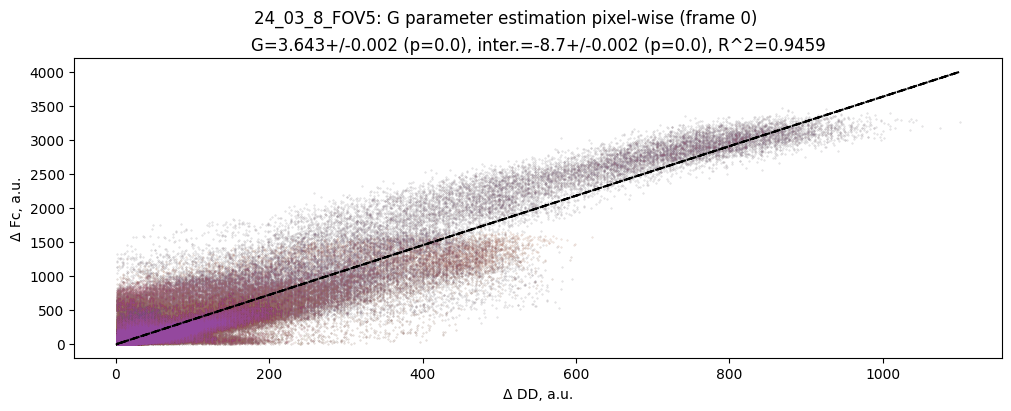

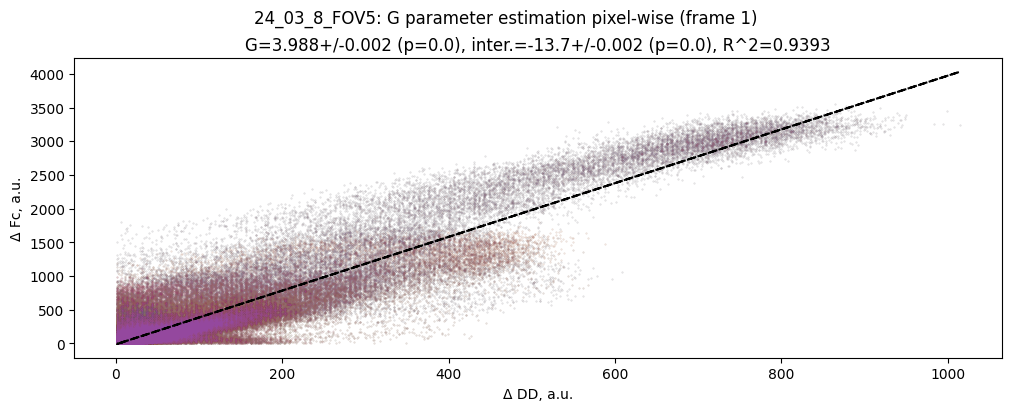

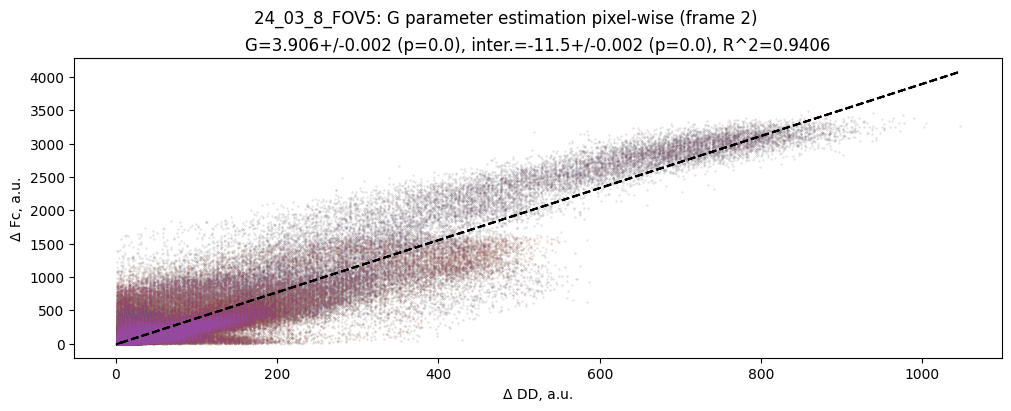

In [30]:
a = 0.12
b = 0.0
c = 0.0
d = 0.79
abcd = [a, b, c, d]

G_fov = coef_calc.GReg(img_name='24_03_8_FOV5',
                       pre_img=pre,
                       post_img=post,
                       coef_list=abcd)

bad = [5]
# G_fov.ch_pic()
G_fov.mask_mean_overlay(sel_img='AA')
G_fov.G_fit_frames(bad_rois=bad)

for i in range(3):
    G_fov.G_fit_px(frame_num=i,bad_rois=bad)


In [ ]:
G_fov.prof_plot()